In [4]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load the dataset
df = pd.read_csv("C://Users//USER//Documents//RealFlipkart_Mobiles.csv")

In [6]:
# Display the first few rows of the dataset
df.head()

,Brand,Model,Color,Memory,Storage,Rating,Selling Price,Original Price
0,OPPO,A53,Moonlight Black,4 GB,64 GB,4.5,11990,13990
1,OPPO,A53,Mint Cream,4 GB,64 GB,4.5,11990,15990
2,OPPO,A53,Moonlight Black,6 GB,128 GB,4.3,13990,17990
3,OPPO,A53,Mint Cream,6 GB,128 GB,4.3,13990,17990
4,OPPO,A53,Electric Black,4 GB,64 GB,4.5,11990,15990


In [7]:
# Check for missing values and data types
print(df.isnull().sum())
print(df.dtypes)


Brand               0
Model               0
Color               0
Memory             43
Storage            39
Rating            144
Selling Price       0
Original Price      0
dtype: int64
Brand              object
Model              object
Color              object
Memory             object
Storage            object
Rating            float64
Selling Price       int64
Original Price      int64
dtype: object


In [8]:
# Drop irrelevant columns and handle missing values
df.drop(['Original Price'], axis=1, inplace=True)
df.dropna(inplace=True)

In [9]:
# Convert 'Memory' and 'Storage' to numeric
df['Memory'] = df['Memory'].str.extract('(\d+)').astype(float)
df['Storage'] = df['Storage'].str.extract('(\d+)').astype(float)


In [10]:
# Feature selection and scaling
features = df[['Memory', 'Storage', 'Rating', 'Selling Price']]
features_standardized = (features - features.mean()) / features.std()

In [11]:
# Define the parameter grid for KMeans
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random'],
    'max_iter': [300, 600, 900]
}

In [12]:
# Initialize the KMeans model
kmeans = KMeans(random_state=42)

In [13]:
# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(kmeans, param_grid, cv=5)
grid_search.fit(features_standardized)


GridSearchCV(cv=5, estimator=KMeans(random_state=42),
             param_grid={'init': ['k-means++', 'random'],
                         'max_iter': [300, 600, 900],
                         'n_clusters': [2, 3, 4, 5]})

In [14]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'init': 'random', 'max_iter': 300, 'n_clusters': 5}


In [15]:
# Train the model with the best parameters
kmeans_best = KMeans(n_clusters=best_params['n_clusters'], 
                     init=best_params['init'], 
                     max_iter=best_params['max_iter'], 
                     random_state=42)


In [16]:
df['Cluster'] = kmeans_best.fit_predict(features_standardized)

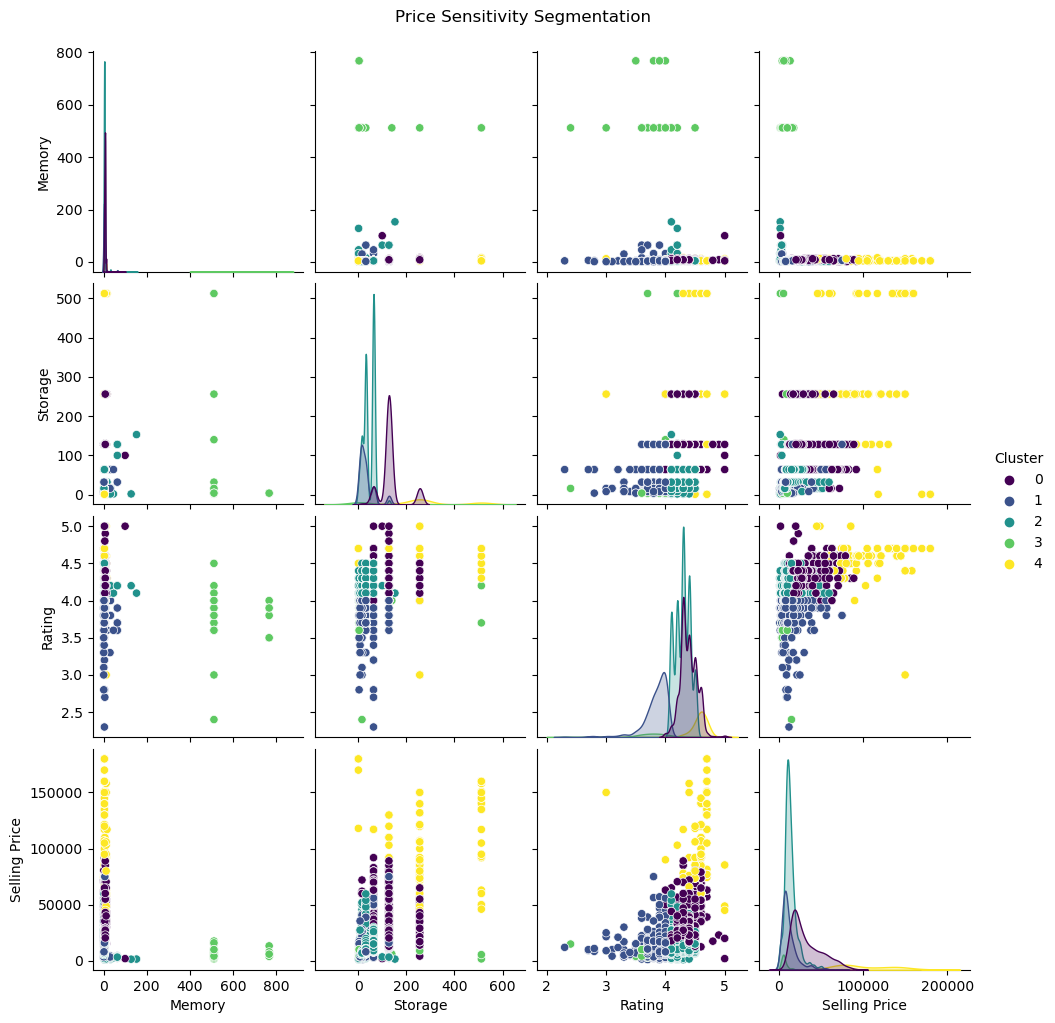

In [17]:
# Visualize Clusters
sns.pairplot(df, vars=['Memory', 'Storage', 'Rating', 'Selling Price'], hue='Cluster', palette='viridis')
plt.suptitle('Price Sensitivity Segmentation', y=1.02)
plt.show()

In [18]:
# Display cluster characteristics
cluster_characteristics = df.groupby('Cluster').mean()
print(cluster_characteristics)

             Memory     Storage    Rating  Selling Price
Cluster                                                 
0          6.243848  133.506711  4.385570   32707.325503
1          4.214418   33.589649  3.833826   12332.530499
2          4.279902   43.727421  4.286981   13686.931652
3        541.538462   32.038462  3.775000    6332.365385
4          5.513812  292.099448  4.570718  102056.331492


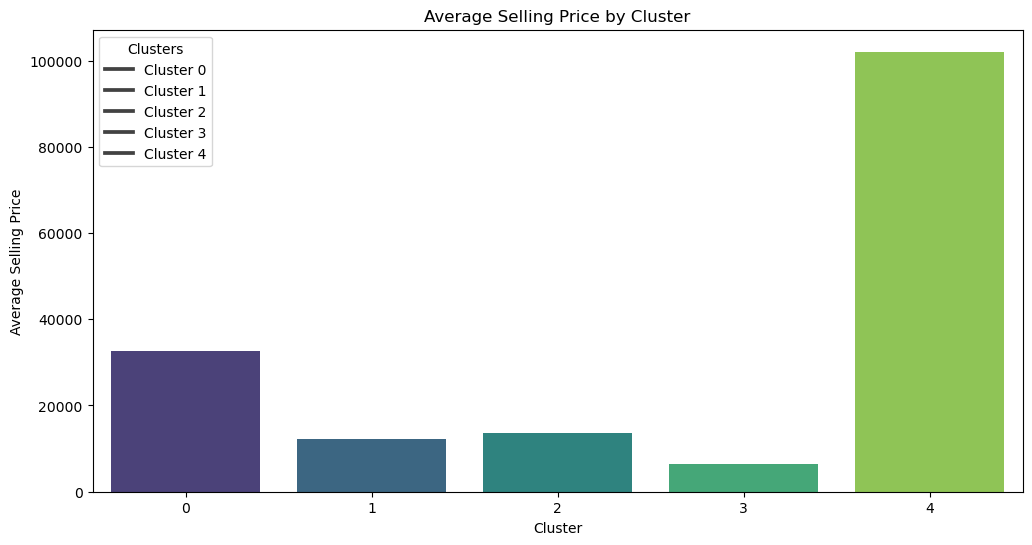

In [19]:
# Additional visualizations for cluster characteristics with keys for interpretation
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_characteristics.index, y='Selling Price', data=cluster_characteristics, palette='viridis')
plt.title('Average Selling Price by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Selling Price')
plt.legend(title='Clusters', labels=[f'Cluster {i}' for i in cluster_characteristics.index])
plt.show()

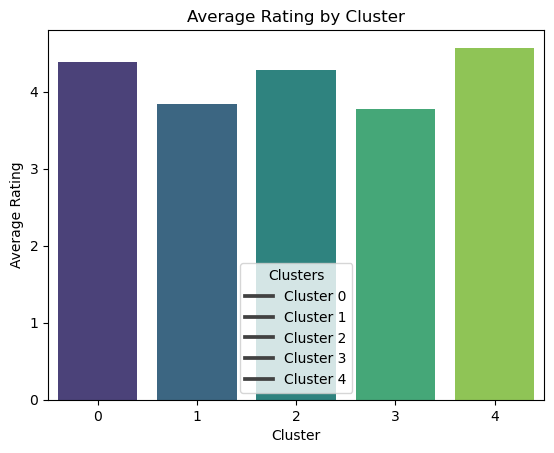

In [20]:
sns.barplot(x=cluster_characteristics.index, y='Rating', data=cluster_characteristics, palette='viridis')
plt.title('Average Rating by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Rating')
plt.legend(title='Clusters', labels=[f'Cluster {i}' for i in cluster_characteristics.index])
plt.show()

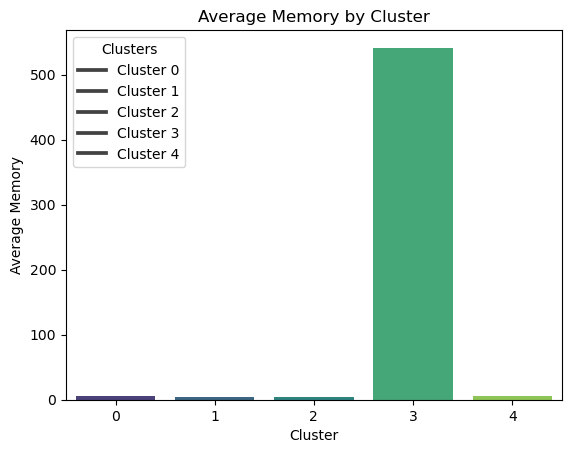

In [21]:
sns.barplot(x=cluster_characteristics.index, y='Memory', data=cluster_characteristics, palette='viridis')
plt.title('Average Memory by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Memory')
plt.legend(title='Clusters', labels=[f'Cluster {i}' for i in cluster_characteristics.index])
plt.show()

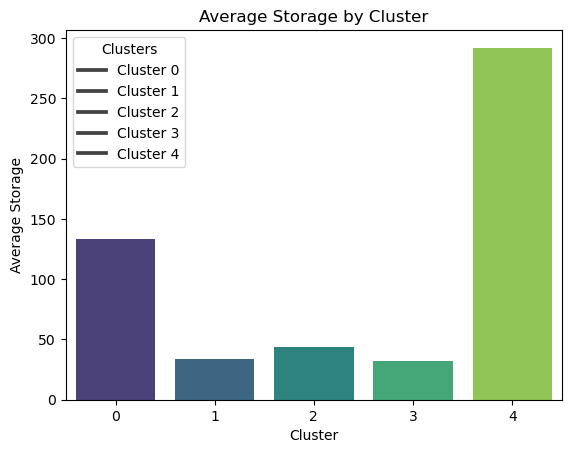

In [22]:
sns.barplot(x=cluster_characteristics.index, y='Storage', data=cluster_characteristics, palette='viridis')
plt.title('Average Storage by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Storage')
plt.legend(title='Clusters', labels=[f'Cluster {i}' for i in cluster_characteristics.index])
plt.show()

In [23]:


import numpy as np

# Calculate percentage change in Selling Price and Rating
df['Price Change'] = df['Selling Price'].pct_change()
df['Rating Change'] = df['Rating'].pct_change()

# Drop NaN values resulting from the percentage change calculation
df.dropna(subset=['Price Change', 'Rating Change'], inplace=True)

# Calculate Elasticity of Demand
df['Elasticity'] = df['Rating Change'] / df['Price Change']

# Handle any infinite or NaN values in Elasticity
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['Elasticity'], inplace=True)

# Calculate the average elasticity for each cluster
average_elasticity_by_cluster = df.groupby('Cluster')['Elasticity'].mean()

# Fill NaN values with 0 if a cluster has no valid elasticity calculation
average_elasticity_by_cluster.fillna(0, inplace=True)

# Display the result in the specified format
for cluster in average_elasticity_by_cluster.index:
    print(f"Cluster {cluster}: Price Elasticity of Demand = {average_elasticity_by_cluster[cluster]:.2f}")


Cluster 0: Price Elasticity of Demand = 0.20
Cluster 1: Price Elasticity of Demand = 0.91
Cluster 2: Price Elasticity of Demand = -0.55
Cluster 3: Price Elasticity of Demand = 2.21
Cluster 4: Price Elasticity of Demand = 0.01
